<a href="https://colab.research.google.com/github/Aleksandra0001/DataScience/blob/main/HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualkeras
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 17.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00


В качестве домашнего задания вам предлагается создать нейронную сеть с помощью механизмов Keras, которая будет классифицировать товары из датасета fasion_mnist.

В отличие от предыдущего задания вам предлагается создать сверточную нейросеть. Подберите архитектуру сети и обучите ее на данных из датасета fasion_mnist. Попытайтесь добиться максимально возможной точности классификации за счет манипуляции параметрами сети. Сравните точность полученной сверточной сети с точностью многослойной сети из предыдущего задания. Сделайте выводы.

In [2]:
from tensorflow import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


[]

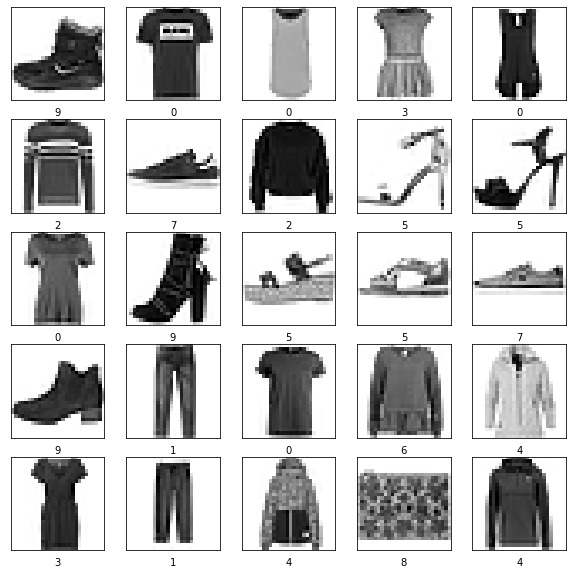

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.xlabel(y_train[i])
  plt.xticks([])
  plt.yticks([])
plt.plot()

In [5]:
# Copyright 2023 Google Research. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""TF2 implementation of the Lion optimizer."""

import tensorflow.compat.v2 as tf


class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config

# Model 1

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import optimizers, metrics, losses, utils
import visualkeras
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv1'),
    MaxPooling2D((2,2), name='MaxPool1'),
    
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv2'),
    MaxPooling2D((2,2), name='MaxPool2'),
    Dropout(.3),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv3'),
    MaxPooling2D((2,2), name='MaxPool3'),

    Flatten(),
    Dense(128, activation='relu', name='FC1'),
    Dropout(.3),
    Dense(10, activation='softmax', name='Prediction')
])

# opt_adamw = AdamW(weight_decay=0.004)
lion_optimizer = Lion()


model.compile(
    optimizer=lion_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                      

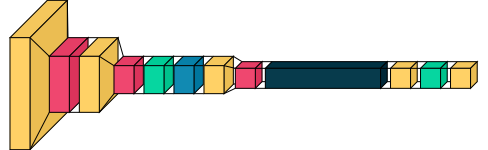

In [21]:
visualkeras.layered_view(model)

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4658859480368709757
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14391508992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9416158904141299788
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, 
    y_train, 
    epochs=50,
    steps_per_epoch=150,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
150/150 [==============================] - 3s 14ms/step - loss: 0.9489 - accuracy: 0.6613 - val_loss: 0.4976 - val_accuracy: 0.8147
Epoch 2/50
150/150 [==============================] - 2s 13ms/step - loss: 0.4827 - accuracy: 0.8238 - val_loss: 0.3725 - val_accuracy: 0.8622
Epoch 3/50
150/150 [==============================] - 2s 11ms/step - loss: 0.3840 - accuracy: 0.8598 - val_loss: 0.3170 - val_accuracy: 0.8852
Epoch 4/50
150/150 [==============================] - 2s 11ms/step - loss: 0.3365 - accuracy: 0.8779 - val_loss: 0.2869 - val_accuracy: 0.8935
Epoch 5/50
150/150 [==============================] - 2s 12ms/step - loss: 0.3067 - accuracy: 0.8880 - val_loss: 0.2658 - val_accuracy: 0.8998
Epoch 6/50
150/150 [==============================] - 2s 11ms/step - loss: 0.2796 - accuracy: 0.8998 - val_loss: 0.2584 - val_accuracy: 0.9051
Epoch 7/50
150/150 [==============================] - 2s 11ms/step - loss: 0.2635 - accuracy: 0.9037 - val_loss: 0.2498 - val_accuracy: 0.9097

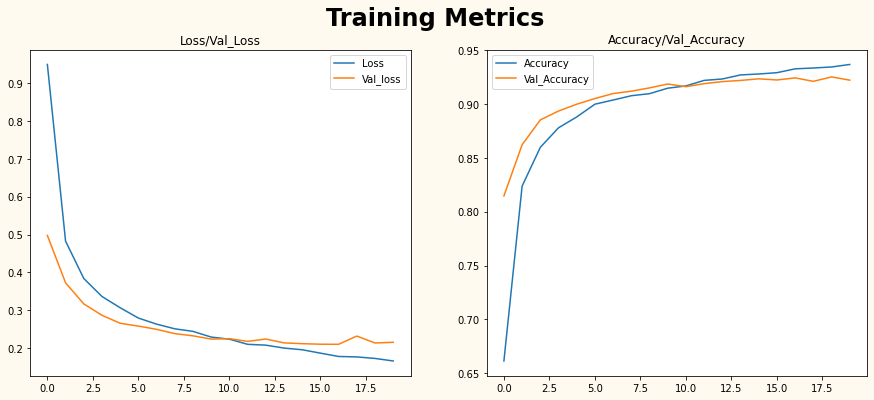

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Training Metrics', fontsize=24, fontweight='bold')
fig.set_facecolor('floralwhite')

axes[0].set_title('Loss/Val_Loss')
axes[0].plot(history.history['loss'], label='Loss')
axes[0].plot(history.history['val_loss'], label='Val_loss')
axes[0].legend()

axes[1].set_title('Accuracy/Val_Accuracy')
axes[1].plot(history.history['accuracy'], label='Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val_Accuracy')
axes[1].legend()

plt.show()

In [24]:
loss_test, acc_test = model.evaluate(x_test, y_test)
print(f'Loss Test: {loss_test}, Accuracy Test: {acc_test}')

313/313 [==============================] - 1s 3ms/step - loss: 0.2366 - accuracy: 0.9205
Loss Test: 0.23655834794044495, Accuracy Test: 0.9204999804496765


313/313 [==============================] - 1s 3ms/step


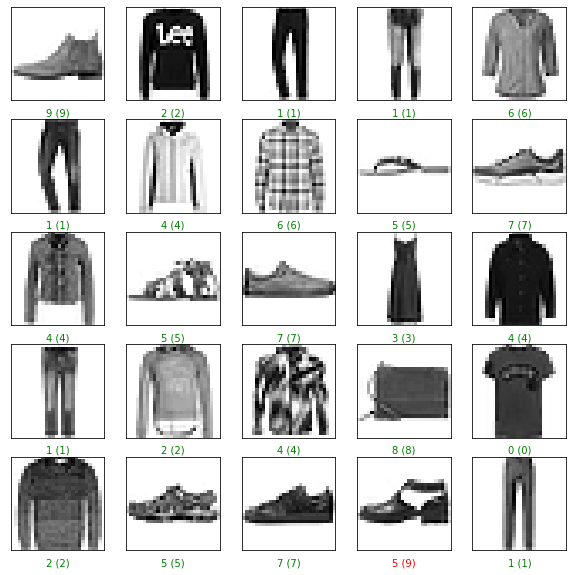

In [25]:
pred = model.predict(x_test)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(pred[i])
    true_label = y_test[i]
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"
    plt.xlabel("{} ({})".format(predicted_label, true_label), color=color)
    
plt.show()

# Model 2

In [127]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import optimizers, metrics, losses, utils, regularizers
import visualkeras
import tensorflow as tf

model_2 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv1'),
    MaxPooling2D((2,2), name='MaxPool1'),
    Dropout(.25),
    
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv2'),
    MaxPooling2D((2,2), name='MaxPool2'),
    Dropout(.25),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(28,28,1), name='Conv3'),
    MaxPooling2D((2,2), name='MaxPool3'),
    Dropout(.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2', name='FC1'),
    Dropout(.1),
    Dense(10, activation='softmax', name='Prediction')
])

lion_optimizer = Lion()

model_2.compile(
    optimizer=lion_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [128]:
model_2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
                                                                 
 dropout_50 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 7, 7, 64)          0         
                                                                 
 dropout_51 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_26 (Bat  (None, 7, 7, 64)       

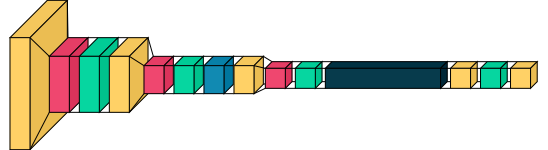

In [129]:
visualkeras.layered_view(model_2)

In [130]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    x_train, 
    y_train, 
    epochs=50,
    steps_per_epoch=100,
    # batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
100/100 [==============================] - 4s 27ms/step - loss: 3.4677 - accuracy: 0.5108 - val_loss: 2.5705 - val_accuracy: 0.7467
Epoch 2/50
100/100 [==============================] - 3s 29ms/step - loss: 2.2867 - accuracy: 0.7311 - val_loss: 1.8802 - val_accuracy: 0.7536
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 1.5514 - accuracy: 0.7879 - val_loss: 1.2721 - val_accuracy: 0.7883
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 1.0239 - accuracy: 0.8286 - val_loss: 0.8264 - val_accuracy: 0.8347
Epoch 5/50
100/100 [==============================] - 3s 29ms/step - loss: 0.6842 - accuracy: 0.8552 - val_loss: 0.5421 - val_accuracy: 0.8739
Epoch 6/50
100/100 [==============================] - 3s 29ms/step - loss: 0.4972 - accuracy: 0.8712 - val_loss: 0.4266 - val_accuracy: 0.8804
Epoch 7/50
100/100 [==============================] - 2s 25ms/step - loss: 0.4085 - accuracy: 0.8811 - val_loss: 0.3594 - val_accuracy: 0.8913

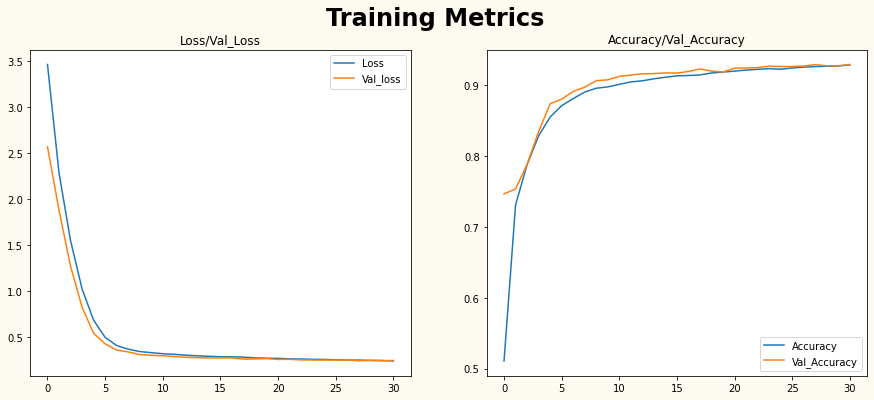

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Training Metrics', fontsize=24, fontweight='bold')
fig.set_facecolor('floralwhite')

axes[0].set_title('Loss/Val_Loss')
axes[0].plot(history_2.history['loss'], label='Loss')
axes[0].plot(history_2.history['val_loss'], label='Val_loss')
axes[0].legend()

axes[1].set_title('Accuracy/Val_Accuracy')
axes[1].plot(history_2.history['accuracy'], label='Accuracy')
axes[1].plot(history_2.history['val_accuracy'], label='Val_Accuracy')
axes[1].legend()

plt.show()

In [132]:
loss_test_2, acc_test_2 = model_2.evaluate(x_test, y_test)
print(f'Loss Test: {loss_test_2}, Accuracy Test: {acc_test_2}')

313/313 [==============================] - 1s 3ms/step - loss: 0.2586 - accuracy: 0.9228
Loss Test: 0.25864988565444946, Accuracy Test: 0.9228000044822693


313/313 [==============================] - 1s 2ms/step


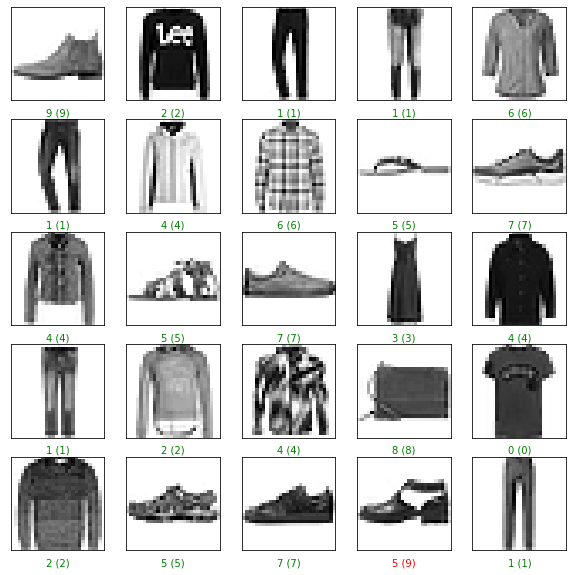

In [133]:
pred_2 = model_2.predict(x_test)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(pred_2[i])
    true_label = y_test[i]
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"
    plt.xlabel("{} ({})".format(predicted_label, true_label), color=color)
    
plt.show()

In [134]:
print(f'Model 1: Loss Test: {loss_test}, Accuracy Test: {acc_test}')
print(f'Model 2: Loss Test: {loss_test_2}, Accuracy Test: {acc_test_2}')

Model 1: Loss Test: 0.23655834794044495, Accuracy Test: 0.9204999804496765
Model 2: Loss Test: 0.25864988565444946, Accuracy Test: 0.9228000044822693
